In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud 
from nltk.tokenize import word_tokenize 


nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
del train['keyword']
del train['location']
del test['keyword']
del test['location']

In [4]:
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.shape, test.shape, test.shape[0]/train.shape[0]

((7613, 3), (3263, 2), 0.4286089583606988)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


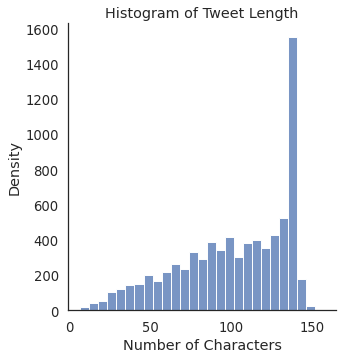

In [7]:
train["tweet_length"] = train["text"].apply(len)
sns.displot(train["tweet_length"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

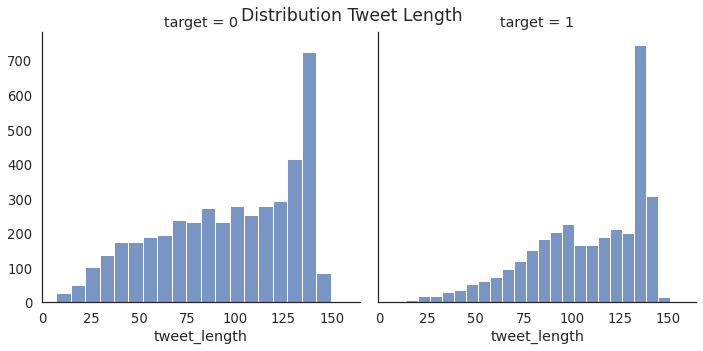

In [8]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.histplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

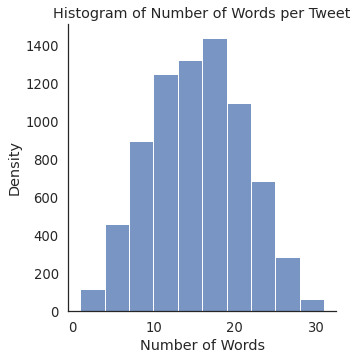

In [9]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)
sns.displot(train["num_words"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

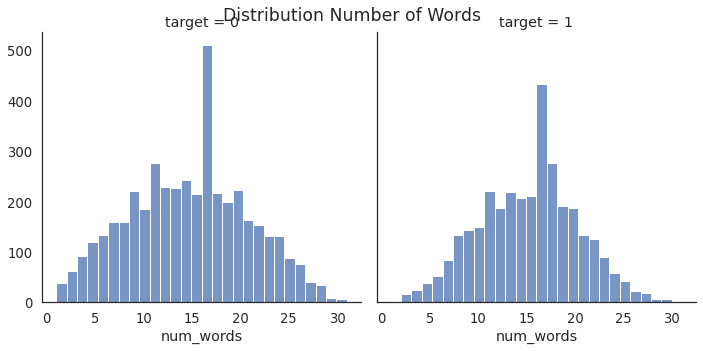

In [10]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.histplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

Not Disaster: 57.03%, Disaster: 42.97%


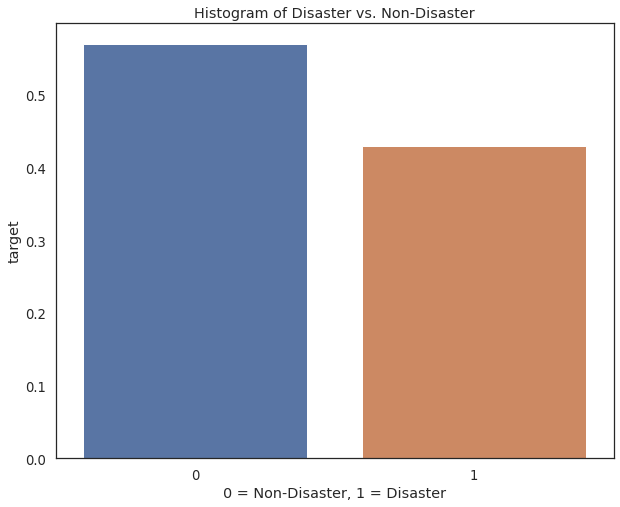

In [11]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

In [12]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))

In [13]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [14]:
import re
import string

In [15]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'URL',text)

def remove_HTML(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_not_ASCII(text):
    text = ''.join([word for word in text if word in string.printable])
    return text

def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

def remove_mention(text):
    at=re.compile(r'@\S+')
    return at.sub(r'USER',text)

def remove_number(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    return num.sub(r'NUMBER', text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'EMOJI', text)

def transcription_sad(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
    return smiley.sub(r'SADFACE', text)

def transcription_smile(text):
    eyes = "[8:=;]"
    nose = "['`\-]"
    smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
    return smiley.sub(r'SMILE', text)

def transcription_heart(text):
    heart = re.compile(r'<3')
    return heart.sub(r'HEART', text)

def remove_elongated_words(text):
    rep = re.compile(r'\b(\S*?)([a-z])\2{2,}\b')
    return rep.sub(r'\1\2 ELONG', text)

def remove_repeat_punctuations(text):
    rep = re.compile(r'([!?.]){2,}')
    return rep.sub(r'\1 REPEAT', text)


def remove_all_punctuations(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" 
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')   
    return text

def remove_stopwords(text):
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text

In [16]:
def clean_tweet(text):
    
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    text = text.lower()
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
    
    text = remove_elongated_words(text)
    text = remove_repeat_punctuations(text)

    text = remove_all_punctuations(text)
    text = remove_punctuations(text)
    text = remove_stopwords(text)

    return text


In [17]:
train["clean_text"] = train["text"].apply(clean_tweet)
test["clean_text"] = test["text"].apply(clean_tweet)

train["clean_tokens"] = train["clean_text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["clean_text"].apply(lambda x: word_tokenize(x))

In [18]:
train[['clean_text','text']].head(10)

,clean_text,text
0,deeds reason earthquake may allah forgive us,Our Deeds are the Reason of this #earthquake M...
1,forest fire near la ronge sask canada,Forest fire near La Ronge Sask. Canada
2,residents asked shelter place notified officer...,All residents asked to 'shelter in place' are ...
3,NUMBER people receive wildfires evacuation ord...,"13,000 people receive #wildfires evacuation or..."
4,got sent photo ruby alaska smoke wildfires pou...,Just got sent this photo from Ruby #Alaska as ...
5,rockyfire update california hwy NUMBER closed ...,#RockyFire Update => California Hwy. 20 closed...
6,flood disaster heavy rain causes flash floodin...,#flood #disaster Heavy rain causes flash flood...
7,im top hill see fire woods REPEAT,I'm on top of the hill and I can see a fire in...
8,theres emergency evacuation happening building...,There's an emergency evacuation happening now ...
9,im afraid tornado coming area REPEAT,I'm afraid that the tornado is coming to our a...


In [19]:
from gensim.models import Word2Vec

skip_gram_model = Word2Vec(train['clean_tokens'],size=150,window=3,min_count=2,sg=1)
skip_gram_model.train(train['clean_tokens'],total_examples=len(train['clean_tokens']),epochs=10)

cbow_model = Word2Vec(train['clean_tokens'],size=150,window=3,min_count=2)
cbow_model.train(train['clean_tokens'],total_examples=len(train['clean_tokens']),epochs=10)


train["clean_tokens"] = train["text"].apply(lambda x: word_tokenize(x))
test["clean_tokens"] = test["text"].apply(lambda x: word_tokenize(x))
def get_word_embeddings(token_list,vector,k=150):
    if len(token_list) < 1:
        return np.zeros(k)
    else:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in token_list] 
        
    sum = np.sum(vectorized,axis=0)
    return sum/len(vectorized) 

In [20]:
from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer
max_features=5000

count_vectorizer = CountVectorizer(max_features=max_features)
sparce_matrix_train=count_vectorizer.fit_transform(train['clean_text'])
sparce_matrix_test=count_vectorizer.fit_transform(train['clean_text'])

def count_vector(data):
    count_vectorizer = CountVectorizer()
    vect = count_vectorizer.fit_transform(data)
    return vect, count_vectorizer

def skip_gram_vectorizer(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, skip_gram_model))
        return list(embeddings)

def cbow_vectorizer(tokens,vector):
        embeddings = tokens.apply(lambda x: get_word_embeddings(x, cbow_model))
        return list(embeddings)

X_train_count, count_vectorizer = count_vector(train['clean_text'])
X_train_skip_gram = skip_gram_vectorizer(train['clean_tokens'],skip_gram_model)
X_train_cbow = cbow_vectorizer(train['clean_tokens'],cbow_model)

X_test_count = count_vectorizer.transform(test['clean_text'])                                                     
X_test_skip_gram = skip_gram_vectorizer(test['clean_tokens'],skip_gram_model)
X_test_cbow = cbow_vectorizer(test['clean_tokens'],cbow_model)

X_train_skip_gram = np.array(X_train_skip_gram)
X_train_cbow = np.array(X_train_cbow)
X_test_skip_gram = np.array(X_test_skip_gram)
X_test_cbow = np.array(X_test_cbow)


/home/lucifer/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  app.launch_new_instance()
/home/lucifer/anaconda3/envs/NLP/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [21]:
metrics = pd.DataFrame(columns=['model' ,'vectoriser', 'train accuracy', 'test accuracy'])

In [22]:
from sklearn.metrics import roc_auc_score
def fit_and_predict(model,x_train,x_test,y_train,y_test,vectoriser):
    classifier = model
    classifier_name = str(classifier.__class__.__name__)

    if classifier_name=="MultinomialNB" and (vectoriser=="skip gram vector" or vectoriser=="cbow vector"):
        return

    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cmatrix = confusion_matrix(y_test,y_pred)


    f,ax = plt.subplots(figsize=(3,3))
    sns.heatmap(cmatrix,annot=True,linewidths=0.5,cbar=False,linecolor="red",fmt='.0f',ax=ax)
    plt.xlabel("y_predict")
    plt.ylabel("y_true")
    ax.set(title=str(classifier))
    plt.show()


    train_accuracy = round(classifier.score(x_train,y_train)*100)
    test_accuracy =  round(accuracy_score(y_test,y_pred)*100)

    print(str(classifier.__class__.__name__) +" using "+ str(vectoriser))
    
    print('Accuracy of classifier on training set:{} %'.format(train_accuracy))
    print('Accuracy of classifier on test set:{} %' .format(test_accuracy))
    
    auc = roc_auc_score(y_test, y_pred)
    print('AUC : {0:.2f} %'.format(auc))


In [23]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [24]:
random_state = 13
models=[
        LogisticRegression(random_state=random_state),
        SVC(random_state=random_state),
        MultinomialNB(),
        DecisionTreeClassifier(random_state = random_state),
        KNeighborsClassifier(),
        RandomForestClassifier(random_state=random_state),
       ]

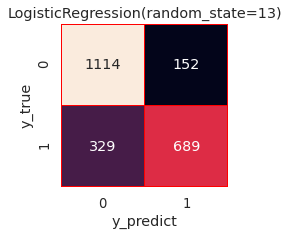

LogisticRegression using Count vector
Accuracy of classifier on training set:96%
Accuracy of classifier on test set:79%
AUC : 0.78%


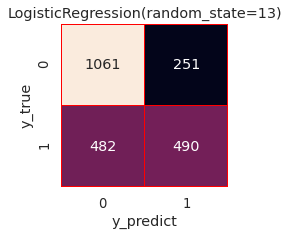

LogisticRegression using skip gram vector
Accuracy of classifier on training set:68%
Accuracy of classifier on test set:68%
AUC : 0.66%


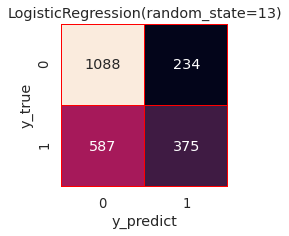

LogisticRegression using cbow vector
Accuracy of classifier on training set:65%
Accuracy of classifier on test set:64%
AUC : 0.61%


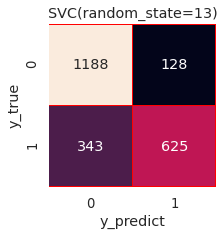

SVC using Count vector
Accuracy of classifier on training set:95%
Accuracy of classifier on test set:79%
AUC : 0.77%


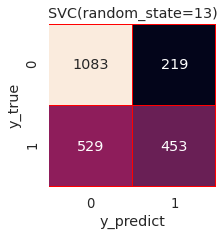

SVC using skip gram vector
Accuracy of classifier on training set:78%
Accuracy of classifier on test set:67%
AUC : 0.65%


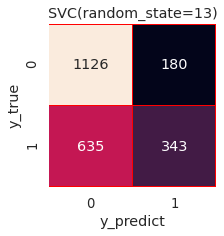

SVC using cbow vector
Accuracy of classifier on training set:73%
Accuracy of classifier on test set:64%
AUC : 0.61%


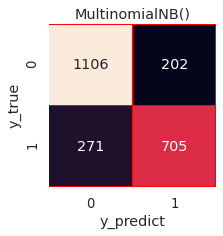

MultinomialNB using Count vector
Accuracy of classifier on training set:91%
Accuracy of classifier on test set:79%
AUC : 0.78%


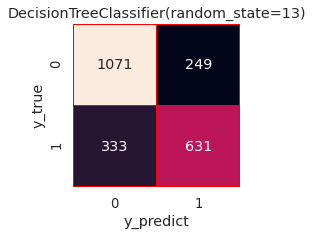

DecisionTreeClassifier using Count vector
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:75%
AUC : 0.73%


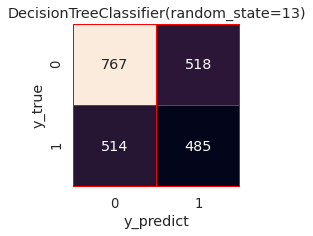

DecisionTreeClassifier using skip gram vector
Accuracy of classifier on training set:100%
Accuracy of classifier on test set:55%
AUC : 0.54%


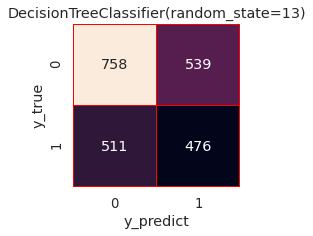

DecisionTreeClassifier using cbow vector
Accuracy of classifier on training set:100%
Accuracy of classifier on test set:54%
AUC : 0.53%


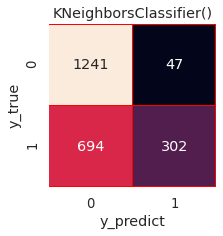

KNeighborsClassifier using Count vector
Accuracy of classifier on training set:75%
Accuracy of classifier on test set:68%
AUC : 0.63%


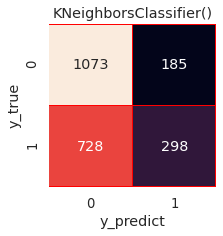

KNeighborsClassifier using skip gram vector
Accuracy of classifier on training set:72%
Accuracy of classifier on test set:60%
AUC : 0.57%


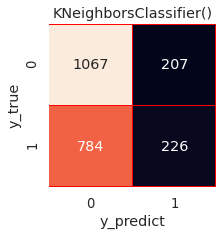

KNeighborsClassifier using cbow vector
Accuracy of classifier on training set:69%
Accuracy of classifier on test set:57%
AUC : 0.53%


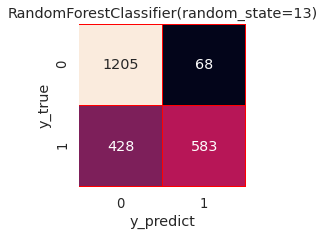

RandomForestClassifier using Count vector
Accuracy of classifier on training set:99%
Accuracy of classifier on test set:78%
AUC : 0.76%


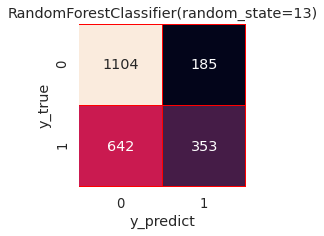

RandomForestClassifier using skip gram vector
Accuracy of classifier on training set:100%
Accuracy of classifier on test set:64%
AUC : 0.61%


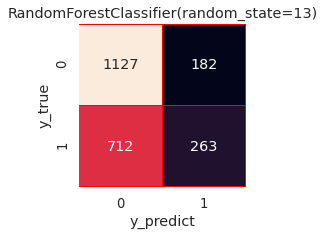

RandomForestClassifier using cbow vector
Accuracy of classifier on training set:100%
Accuracy of classifier on test set:61%
AUC : 0.57%


In [25]:
for model in models:
    y = train.target

    x = X_train_count
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test,'Count vector')
    
    x = X_train_skip_gram
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'skip gram vector')
    
    x = X_train_cbow
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
    fit_and_predict(model,x_train,x_test,y_train,y_test, 'cbow vector')  